In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
import lib
np.random.seed(666)

In [2]:
rootfolder = '..'

Useful function for plot the 2D DCT dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [4]:
# see lib.py

Load the image and rescale it in $[0,1]$

In [5]:
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2

Corrupt the image with white gaussian noise

In [6]:
sigma_noise = 20/255
noisy_img = img + sigma_noise * np.random.randn(*img.shape)

Compute the psnr of the noisy input

In [7]:
psnr_noisy = lib.psnr(img, noisy_img)

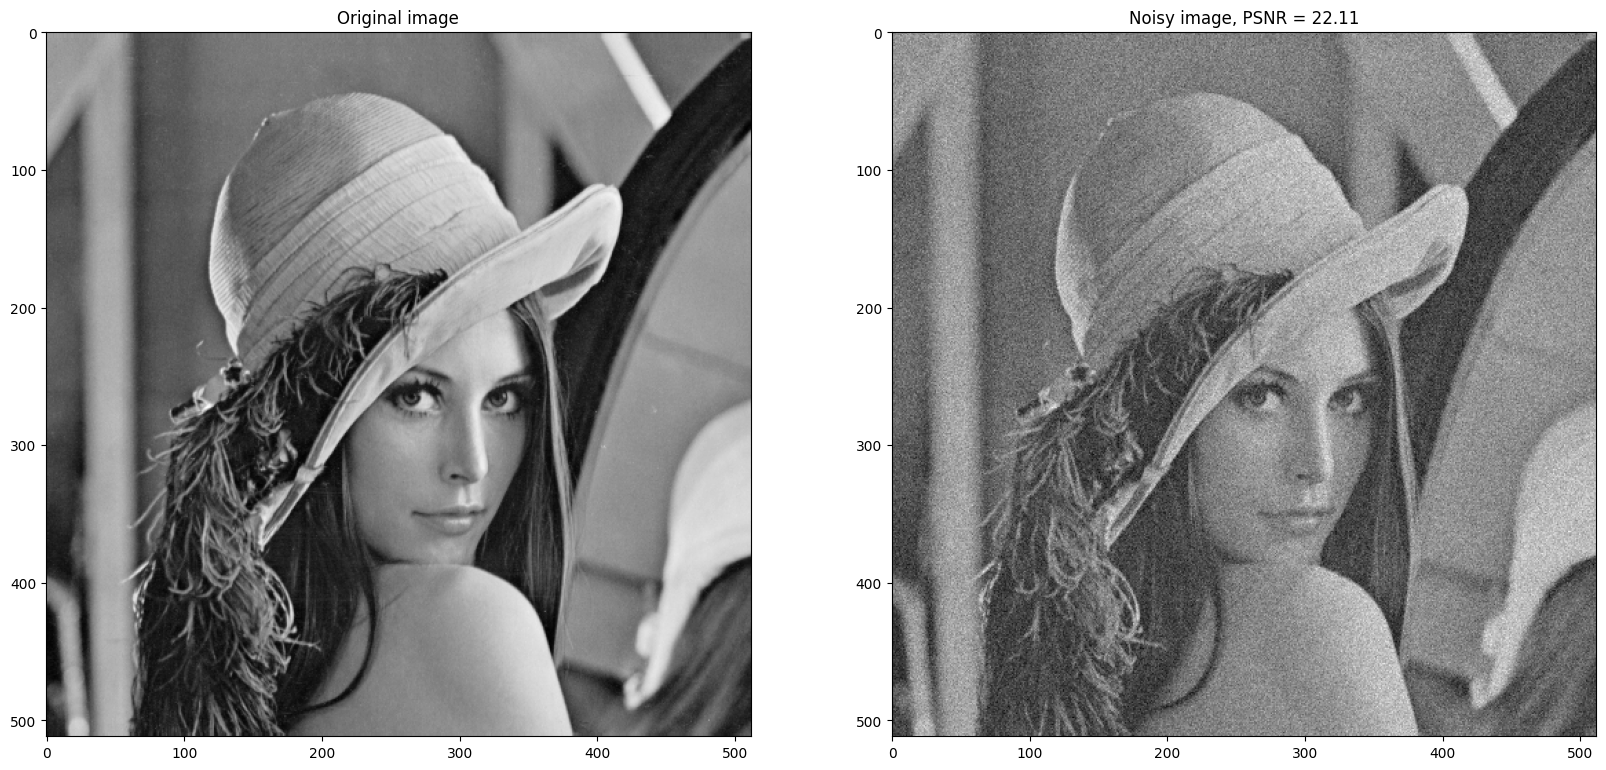

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}');

Load and display the dictionary learned from patches

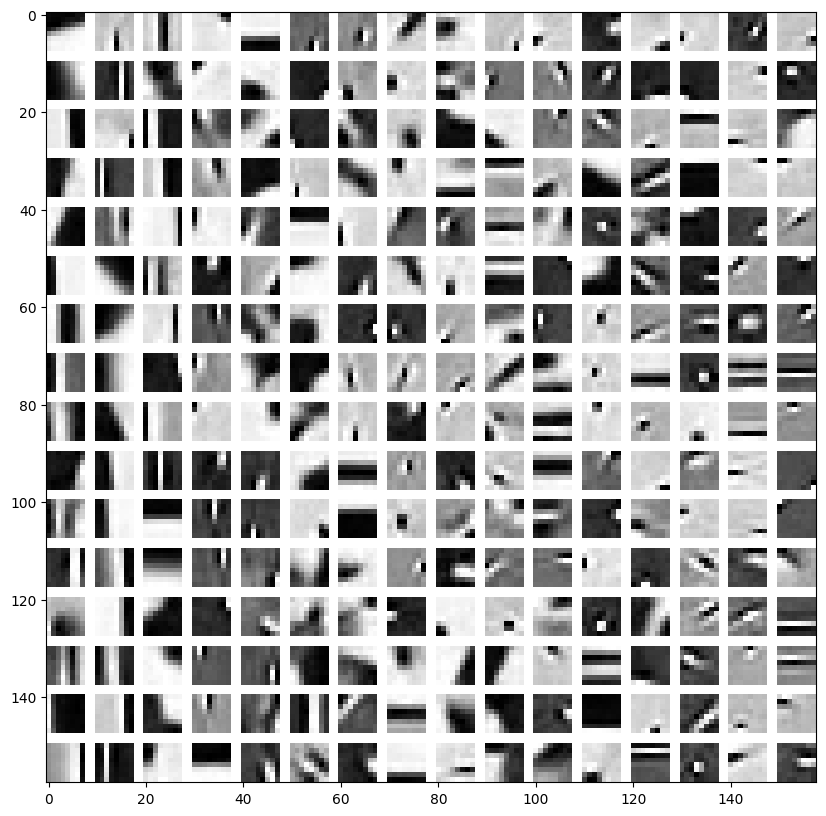

In [9]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# display the dct basis
D_img = get_dictionary_img(D)
plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray');

Denoising
---------


In [10]:
# initialize the estimated image
img_hat = np.zeros(imsz)

# initialize the weight matrix
weights = np.zeros(imsz)

# set the threshold
tau = 1.15 * p * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [11]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p].flatten()

        # store and subtract the mean
        us = s.mean()
        s -= us

        # perform the sparse coding
        lsomp = lib.MatchingPursuit(M, lib.MatchingPursuit.Mode.ORTHOGONAL, max_iter=1000, atol=tau)
        x = lsomp.fit(D, s)

        # perform the reconstruction
        s_hat = np.dot(D, x)

        # add back the mean
        s_hat += us

        img_hat[i:i+p, j:j+p] += s_hat.reshape(p, p)
        weights[i:i+p, j:j+p] += 1

Normalize the estimated image with the computed weights

In [12]:
img_hat /= weights

Compute the psnr of the estimated image

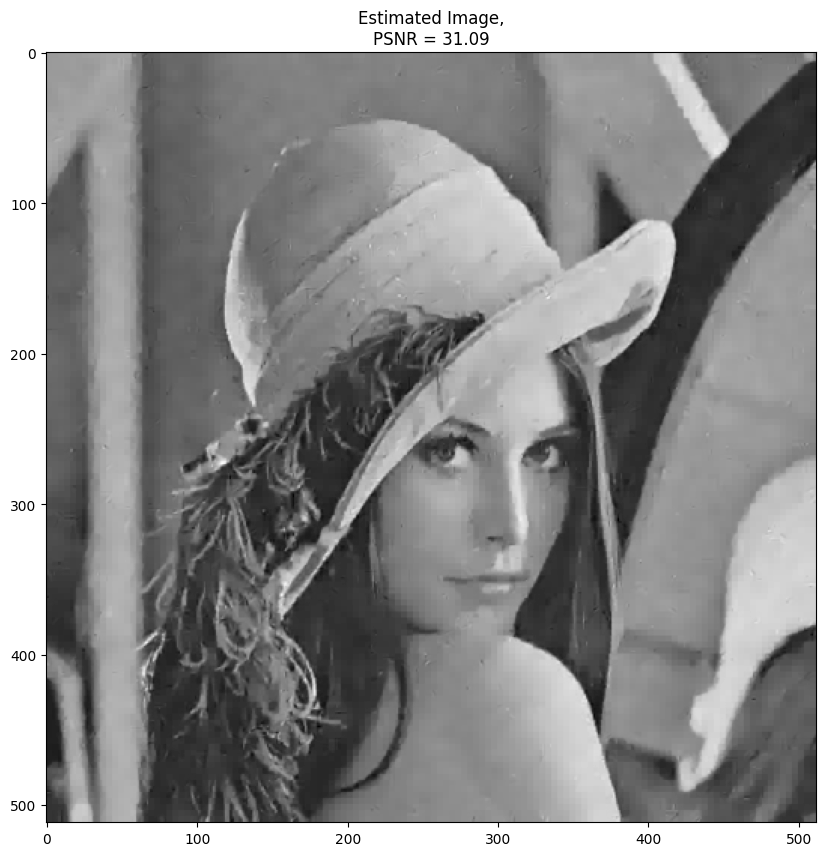

In [13]:
psnr_hat = lib.psnr(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}');